__Objective__: The OIMA identifies mis-reported units by looking for deviations from average gallons per capita day. The prod and delivery files contain a GPCD column, but the data dictionary does not specify if this value was calculated from the original units or the OIMA's revised units. Explore data to attempt to determine if GPCD is calculated in revised or original units.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
pd.set_option('display.width', 5000) 
pd.set_option('display.max_colwidth', -1) 
pd.set_option('display.max_columns', 60)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
processed_data_path  ="/Users/elenasmith/Documents/personal/water_git/data/interim/"

In [4]:
prod = pd.read_csv("{}2_explore_unit_correction___prod_before_unit_conversion.csv".format(processed_data_path))
deliv = pd.read_csv("{}2_explore_unit_correction___deliv_before_unit_conversion.csv".format(processed_data_path))

deliv['gpcd_numeric'] = deliv['CALCULATED GPCD (Total delivery to residential in gallons per capita day)'].apply(lambda x: pd.to_numeric(str(x).replace(",",""),errors='coerce'))
prod['gpcd_numeric'] = prod['CALCULATED GPCD (Total Potable Produced in gallons per capita day)'].apply(lambda x: pd.to_numeric(str(x).replace(",",""),errors='coerce'))

In [5]:
deliv_gallons_col = 'Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric'
revised_num_col = 'WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric'
revised_units_col = 'Delivered.Water.Units.Revised BY OFFICE OF INFORMATION MANAGEMENT AND ANALYSIS'
original_units_col =  'Delivered.Water.Units AS ORIGINALLY REPORTED'

### Is the provided GPCD equal to  "Total. RESIDENTIAL Delivered.Gallons" / population / days in month?

In [6]:
deliv['total_deliv_in_gallons_div_resid_deliv_gallons'] = (deliv[deliv_gallons_col] / deliv['Population Of Service Area']) / deliv['Days.In.Month']
deliv['gpcd_minus_total_deliv_in_gallons_div_resid_deliv_gallons'] = deliv['gpcd_numeric'] - deliv['total_deliv_in_gallons_div_resid_deliv_gallons']
deliv['pct_diff_gpcd_vs_total_deliv_in_gallons_div_resid_deliv_gallons'] = deliv['gpcd_minus_total_deliv_in_gallons_div_resid_deliv_gallons'] / deliv['gpcd_numeric']

% with non-0 GPCD: 0.9423358687204576
% with < 1% error: 0.9675783837864879
% with < 0.05% error: 0.9509214066492706


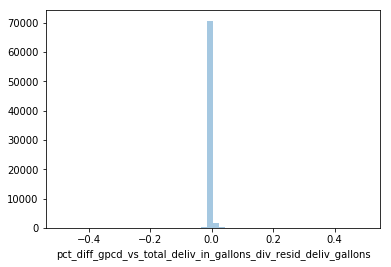

In [7]:
print("% with non-0 GPCD: {}".format(deliv[deliv['gpcd_numeric'] > 0].shape[0]  / deliv.shape[0]))
excl_0 = deliv[deliv['gpcd_numeric'] > 0]
print("% with < 1% error: {}".format(excl_0[(np.abs(excl_0['pct_diff_gpcd_vs_total_deliv_in_gallons_div_resid_deliv_gallons']) < 0.01) ].shape[0]  / excl_0.shape[0]))
print("% with < 0.05% error: {}".format(excl_0[(np.abs(excl_0['pct_diff_gpcd_vs_total_deliv_in_gallons_div_resid_deliv_gallons']) < 0.005) ].shape[0]  / excl_0.shape[0]))

sns.distplot(excl_0['pct_diff_gpcd_vs_total_deliv_in_gallons_div_resid_deliv_gallons'],kde=False)
plt.show()

### Is the provided GPCD equal to "Total.Delivered Residential IN REVISED UNITS " /population / days in month?

In [8]:
deliv['total_deliv_in_revised_div_resid_deliv_gallons'] = (deliv[revised_num_col] / deliv['Population Of Service Area']) / deliv['Days.In.Month']
deliv['gpcd_minus_total_deliv_in_revised_div_resid_deliv_gallons'] = deliv['gpcd_numeric'] - deliv['total_deliv_in_revised_div_resid_deliv_gallons']
deliv['pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons'] = deliv['gpcd_minus_total_deliv_in_revised_div_resid_deliv_gallons'] / deliv['gpcd_numeric']
excl_0 = deliv[deliv['gpcd_numeric'] > 0]

% with < 1% error: 0.3925070643429823
% with < 0.05% error: 0.3784189391993294


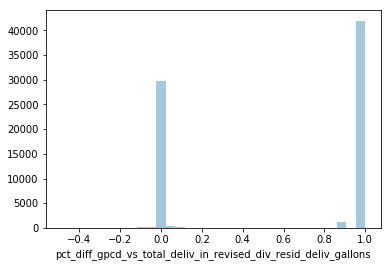

In [9]:
print("% with < 1% error: {}".format(excl_0[(np.abs(excl_0['pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons']) < 0.01) ].shape[0]  / excl_0.shape[0]))
print("% with < 0.05% error: {}".format(excl_0[(np.abs(excl_0['pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons']) < 0.005) ].shape[0]  / excl_0.shape[0]))

sns.distplot(excl_0['pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons'],kde=False)
plt.show()

In [10]:
# Among records with > 1% error, are the revised units not in gallons? 

In [11]:
# moderate error: more than 2%
excl_0[np.abs(excl_0['pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons']) > 0.01][revised_units_col].value_counts().reset_index()

,index,Delivered.Water.Units.Revised BY OFFICE OF INFORMATION MANAGEMENT AND ANALYSIS
0,CCF,21592
1,MG,11828
2,AF,8406
3,G,1852
4,CF,1092
5,HG,78
6,DG,60
7,TG,24


In [12]:
# extreme error: Greater than 50%
excl_0[np.abs(excl_0['pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons']) > 0.5][revised_units_col].value_counts().reset_index()

,index,Delivered.Water.Units.Revised BY OFFICE OF INFORMATION MANAGEMENT AND ANALYSIS
0,CCF,21592
1,MG,11828
2,AF,8406
3,CF,1092
4,HG,78
5,DG,60
6,TG,24


### Is the "TOTAL POTABLE WATER IN GALLONS" equal to the "TOTAL POTABLE WATER PRODUCED USING REVISED UNITS" when converted from revised units to Gallons?

In [13]:
# key = original unit
# value = multiplication factor to obtain gallons
conversionDict = {"AF": 325851.43,
                  "CF": 7.48051948,
                "CCF": 748.051948,
                  "DG": 10,
                  "G":1,
                  "HG": 100.,
                  "MG": 1000000.,
                 "TG": .1}

In [14]:
print(deliv.shape)
deliv_oima_units = deliv[deliv[revised_units_col]!="-"]
print(deliv_oima_units.shape)

(78489, 41)
(77699, 41)


In [15]:
deliv_oima_units['total_deliv_in_revised_conv_to_gallons'] = deliv_oima_units[[revised_num_col,revised_units_col]].apply(lambda x: conversionDict[x[1]]*x[0],axis=1)  

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
deliv_oima_units['diff_deliv_revised_to_deliv_gallons'] = deliv_oima_units['total_deliv_in_revised_conv_to_gallons'] - deliv_oima_units[deliv_gallons_col]
deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'] = deliv_oima_units['diff_deliv_revised_to_deliv_gallons'] / deliv_oima_units[deliv_gallons_col]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


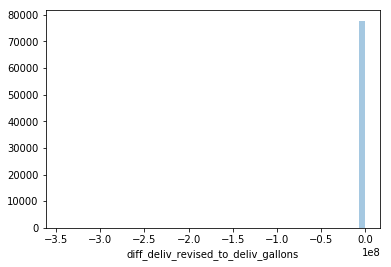

In [17]:
sns.distplot(deliv_oima_units['diff_deliv_revised_to_deliv_gallons'],kde=False)
plt.show()

In [18]:
print("% with < 0.01 unit of error: {}".format(deliv_oima_units[(np.abs(deliv_oima_units['diff_deliv_revised_to_deliv_gallons']) < 0.01) ].shape[0]  / deliv_oima_units.shape[0]))
print("% with < 1 units of error: {}".format(deliv_oima_units[(np.abs(deliv_oima_units['diff_deliv_revised_to_deliv_gallons']) < 1) ].shape[0]  / deliv_oima_units.shape[0]))
print("% with < 2 units of error: {}".format(deliv_oima_units[(np.abs(deliv_oima_units['diff_deliv_revised_to_deliv_gallons']) < 2) ].shape[0]  / deliv_oima_units.shape[0]))

% with < 0.01 unit of error: 0.8436530714681013
% with < 1 units of error: 0.9025727486840243
% with < 2 units of error: 0.9140272075573688


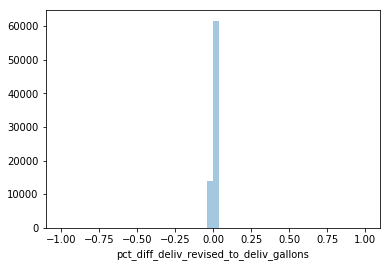

In [19]:
sns.distplot(deliv_oima_units[pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False]['pct_diff_deliv_revised_to_deliv_gallons'],kde=False)
plt.show()

In [20]:
print("% with < 0.01% of error: {}".format(deliv_oima_units[(np.abs(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons']) < 0.01)
                                                              & (pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False) ].shape[0]  / deliv_oima_units[(pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False)].shape[0]))
print("% with < 1% of error: {}".format(deliv_oima_units[(np.abs(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons']) < 1)
                                                              & (pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False)].shape[0]  / deliv_oima_units[(pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False)].shape[0]))
print("% with < 2% of error: {}".format(deliv_oima_units[(np.abs(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons']) < 2)
                                                              & (pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False)].shape[0]  / deliv_oima_units[(pd.isnull(deliv_oima_units['pct_diff_deliv_revised_to_deliv_gallons'])==False)].shape[0]))

% with < 0.01% of error: 0.9955475458496766
% with < 1% of error: 0.9997614756705184
% with < 2% of error: 1.0


Finding: When the 'WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric' column is converted from revised units to gallons, the value is within 1% of the value in 'Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric'

Thus, if we want to recover the ORIGINAL value on the report, we need to convert the value in 'WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric'  from the revised units to the original units.

### Convert 'WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric' from revised units to original units in order to recover values on original report

In [21]:
deliv_oima_units[ (deliv_oima_units[original_units_col]!="-")
                & (deliv_oima_units[revised_units_col]!=deliv_oima_units[original_units_col])].groupby([revised_units_col,original_units_col]).count().reset_index().sort_values('PWSID',ascending=False)

,Delivered.Water.Units.Revised BY OFFICE OF INFORMATION MANAGEMENT AND ANALYSIS,Delivered.Water.Units AS ORIGINALLY REPORTED,PWSID,Water.System.Name,Water.System.Classification,Year,Month,Date,Days.In.Month,UNITS ADJUSTED BY OIMA?,WATER DELIVERIES TO Single.family.Residential,WATER DELIVERIES TO Multi.family.Residential,WATER DELIVERIES TO Commercial.Institutional,WATER DELIVERIES TO Industrial,WATER DELIVERIES TO Landscape.Irrigation,WATER DELIVERIES TO Other,WATER DELIVERIES TO Agricultural,WATER DELIVERIES TO Other.PWS,"WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)","Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)",Population Of Service Area,CALCULATED GPCD (Total delivery to residential in gallons per capita day),WATER DELIVERIES TO Multi.family.Residential_numeric,WATER DELIVERIES TO Commercial.Institutional_numeric,WATER DELIVERIES TO Industrial_numeric,WATER DELIVERIES TO Landscape.Irrigation_numeric,WATER DELIVERIES TO Other_numeric,WATER DELIVERIES TO Agricultural_numeric,WATER DELIVERIES TO Other.PWS_numeric,"WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric","Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric",original_units_incorrect,units_unavailable,key,gpcd_numeric,total_deliv_in_gallons_div_resid_deliv_gallons,gpcd_minus_total_deliv_in_gallons_div_resid_deliv_gallons,pct_diff_gpcd_vs_total_deliv_in_gallons_div_resid_deliv_gallons,total_deliv_in_revised_div_resid_deliv_gallons,gpcd_minus_total_deliv_in_revised_div_resid_deliv_gallons,pct_diff_gpcd_vs_total_deliv_in_revised_div_resid_deliv_gallons,total_deliv_in_revised_conv_to_gallons,diff_deliv_revised_to_deliv_gallons,pct_diff_deliv_revised_to_deliv_gallons
5,CF,CCF,1044,1044,1044,1044,1044,1044,1044,1044,1017,342,501,114,325,232,84,24,1044,1044,1044,1044,342,501,114,325,232,84,24,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044
11,G,MG,320,320,320,320,320,320,320,320,260,36,165,36,59,34,0,1,320,320,320,320,36,165,36,59,34,0,1,320,320,320,320,320,320,320,320,320,320,320,320,320,320,320
10,G,CCF,242,242,235,242,242,242,242,242,230,120,108,48,84,60,0,0,242,242,242,242,120,108,48,84,60,0,0,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242
14,MG,G,132,132,132,132,132,132,132,132,108,36,72,48,36,30,12,0,132,132,132,132,36,72,48,36,30,12,0,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
0,AF,CCF,126,126,126,126,126,126,126,126,114,18,24,6,12,24,36,48,126,126,126,126,18,24,6,12,24,36,48,126,126,126,126,126,114,123,114,114,123,114,114,126,126,123
2,CCF,AF,120,120,120,120,120,120,120,120,120,72,84,48,36,36,0,12,120,120,120,120,72,84,48,36,36,0,12,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
3,CCF,G,108,108,108,108,108,108,108,108,96,72,96,60,70,36,0,0,108,108,108,108,72,96,60,70,36,0,0,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108
4,CCF,MG,102,102,102,102,102,102,102,102,102,83,96,36,58,31,0,0,102,102,102,102,83,96,36,58,31,0,0,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102
12,HG,G,78,78,78,78,78,78,78,78,66,0,12,0,0,0,0,0,78,78,78,78,0,12,0,0,0,0,0,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78
13,MG,CCF,71,71,71,71,71,71,71,71,71,65,71,54,58,38,12,12,71,71,71,71,65,71,54,58,38,12,12,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71


In [22]:
revisedToOriginalConversionDict = {
    'CF_CCF': 0.01,
    'G_MG': 1/float(1000000),
    'G_CCF':748.051948,
    'MG_G': 1000000.,
    'AF_CCF': 435.6,
    'CCF_AF': 1/435.6,
    'CCF_G': 1/748.051948,
    'CCF_MG': (1/748.051948)/float(1000000),
    'HG_G': 100.,
    'MG_CCF' : 748.051948*1000000.,
    'DG_G': 10.,
    'TG_G': 0.1,
    'AF_G': 325851.43,
    'CF_G': 7.48051948,
    'DG_CCF': 748.051948*10.,
    'G_AF': 1/325851.43,
    'G_G': 1,
    'CCF_CCF':1,
    'MG_MG':1,
    'AF_AF':1
}

In [23]:
print(deliv_oima_units.shape)
deliv_oima_units = deliv_oima_units[ (deliv_oima_units[original_units_col]!="-")]
print(deliv_oima_units.shape)

(77699, 44)
(74962, 44)


In [24]:
deliv_oima_units['revised_units_to_original_units']  = deliv_oima_units[[revised_units_col,original_units_col]].apply(lambda x: "{}_{}".format(x[0],x[1]),axis=1 )

In [25]:
deliv_oima_units['original_delivered_value'] = deliv_oima_units[['revised_units_to_original_units',revised_num_col]].apply(lambda x: revisedToOriginalConversionDict[x[0]]*x[1],axis=1)

### Convert value in original units to gallons; calculate GPCD

In [26]:
deliv_oima_units['original_delivered_value_in_gallons'] = deliv_oima_units[[original_units_col,'original_delivered_value']].apply(lambda x: conversionDict[x[0]]*x[1],axis=1)  

In [27]:
deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'] = (deliv_oima_units['original_delivered_value_in_gallons']/ deliv_oima_units['Population Of Service Area']) / deliv_oima_units['Days.In.Month']

### Explore GPCD among GPCD reported in incorrect units

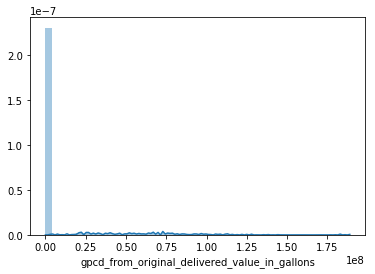

In [28]:
incorrectUnitsGPCD = deliv_oima_units[ (deliv_oima_units['original_units_incorrect']==1)
                     & (pd.isnull(deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'])==False)
                    & (np.isinf(deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'])==False)]['gpcd_from_original_delivered_value_in_gallons']
sns.distplot(incorrectUnitsGPCD)
plt.show()

In [29]:
incorrectUnitsGPCD.describe(percentiles=[0.1,.25,.5,.75,.9])

count   2,451.00      
mean    7,915,834.62  
std     23,313,854.91 
min     0.00          
10%     1.05          
25%     66.48         
50%     123.99        
75%     244.41        
90%     33,211,568.46 
max     188,844,776.03
Name: gpcd_from_original_delivered_value_in_gallons, dtype: float64

### Explore GPCD among GPCD reported in correct units

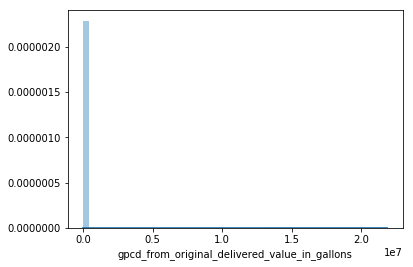

In [30]:
correctUnitsGPCD = deliv_oima_units[ (deliv_oima_units['original_units_incorrect']==0)
                     & (pd.isnull(deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'])==False)
                    & (np.isinf(deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'])==False)]['gpcd_from_original_delivered_value_in_gallons']
sns.distplot(correctUnitsGPCD)
plt.show()

In [31]:
correctUnitsGPCD.describe(percentiles=[0.1,.25,.5,.75,.9])

count   70,412.00    
mean    3,229.74     
std     232,095.48   
min     -291.56      
10%     10.52        
25%     48.64        
50%     96.49        
75%     170.15       
90%     336.69       
max     21,867,914.39
Name: gpcd_from_original_delivered_value_in_gallons, dtype: float64

In [32]:
### Review incorrect units that have comparable GPCD to correct units

In [33]:
comp = deliv_oima_units[ (deliv_oima_units['original_units_incorrect']==1)
                     & (pd.isnull(deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'])==False)
                    & (np.isinf(deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'])==False)
                & (deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'] > 48)
                 & (deliv_oima_units['gpcd_from_original_delivered_value_in_gallons'] < 170)]

In [34]:
comp['diff_gpcd_from_original_g_vs_gpcd_numeric'] = comp['gpcd_from_original_delivered_value_in_gallons'] - comp['gpcd_numeric']
comp['pct_diff_gpcd_from_original_g_vs_gpcd_numeric'] = comp['diff_gpcd_from_original_g_vs_gpcd_numeric']  / comp['gpcd_numeric']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


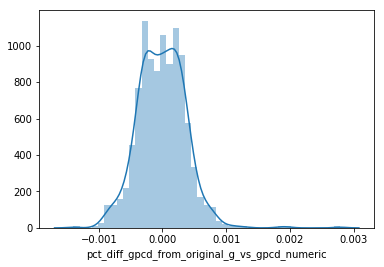

In [35]:
sns.distplot(comp['pct_diff_gpcd_from_original_g_vs_gpcd_numeric'])
plt.show()

In [36]:
comp.shape

(1083, 50)

In [37]:
comp['revised_units_to_original_units'].value_counts()

CF_CCF    664
G_MG      129
CCF_AF    77 
MG_G      73 
HG_G      58 
AF_CCF    56 
CF_G      8  
G_AF      7  
DG_G      7  
AF_G      4  
Name: revised_units_to_original_units, dtype: int64

In [38]:
comp[0:5][['Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric',
           'WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric',
           'revised_units_to_original_units','original_delivered_value','original_delivered_value_in_gallons']]

,"Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric","WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric",revised_units_to_original_units,original_delivered_value,original_delivered_value_in_gallons
1217,"3,350,629.40","447,914.00",CF_CCF,"4,479.14","3,350,629.40"
1218,"4,241,611.64","567,021.00",CF_CCF,"5,670.21","4,241,611.64"
1222,"3,866,194.29","516,835.00",CF_CCF,"5,168.35","3,866,194.29"
1229,"2,939,559.90","392,962.00",CF_CCF,"3,929.62","2,939,559.90"
1230,"3,897,148.68","520,973.00",CF_CCF,"5,209.73","3,897,148.68"


* For these records, the total residential delivery gallons column appears to be calculated from the original units, not the revised units.
* Try calculating GPCD from the "WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric" column, but assume the values are in the original units (do not convert from revised units to original units).

### Calculate GPCD from ""WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS", but assume the value is in the original units

In [39]:
deliv_oima_units['water_deliv_residential_revised_units_in_orig_units_to_gallons'] = deliv_oima_units[[original_units_col,revised_num_col]].apply(lambda x: conversionDict[x[0]]*x[1],axis=1) 
deliv_oima_units['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'] = (deliv_oima_units['water_deliv_residential_revised_units_in_orig_units_to_gallons']/ deliv_oima_units['Population Of Service Area']) / deliv_oima_units['Days.In.Month']

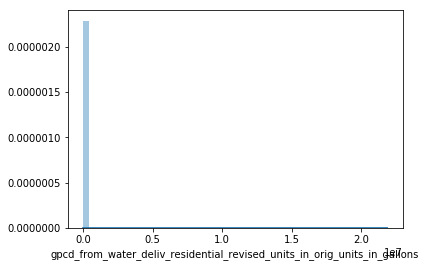

In [40]:
correctUnitsGPCD = deliv_oima_units[ (deliv_oima_units['original_units_incorrect']==0)
                     & (pd.isnull(deliv_oima_units['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'])==False)
                    & (np.isinf(deliv_oima_units['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'])==False)]['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']
sns.distplot(correctUnitsGPCD)
plt.show()

In [41]:
correctUnitsGPCD.describe(percentiles=[0.1,.25,.5,.75,.9])

count   70,412.00    
mean    3,229.74     
std     232,095.48   
min     -291.56      
10%     10.52        
25%     48.64        
50%     96.49        
75%     170.15       
90%     336.69       
max     21,867,914.39
Name: gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons, dtype: float64

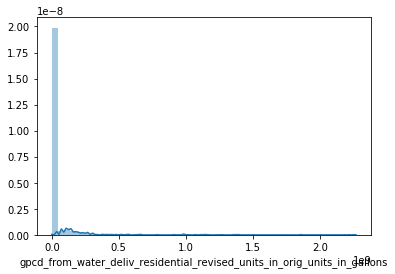

In [42]:
incorrectUnitsGPCD = deliv_oima_units[ (deliv_oima_units['original_units_incorrect']==1)
                     & (pd.isnull(deliv_oima_units['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'])==False)
                    & (np.isinf(deliv_oima_units['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'])==False)]['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']
sns.distplot(incorrectUnitsGPCD)
plt.show()

In [43]:
incorrectUnitsGPCD.describe(percentiles=[0.1,.25,.5,.75,.9])

count   2,451.00        
mean    25,848,618.24   
std     122,647,998.51  
min     0.00            
10%     0.11            
25%     3,723.11        
50%     13,814.03       
75%     57,109.54       
90%     36,912,508.34   
max     2,271,723,220.16
Name: gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons, dtype: float64

In [44]:
deliv_oima_units.to_csv("{}3_explore_gpcd___gpcdFromOriginalReport.csv".format(processed_data_path))